# Overnight photometry recording analysis with FED3 behavioral data - single trial

This script will analyze and save behavioral data recorded from a Feeding Experimentation Device (FED3), align this data to a simultaneously-acquired long-term recording of neural activity using fiber photometry, and perform exploratory analyses of this combined data.

This script should be run after running 'Single_Overnight_Analysis', within the same directory. The directory should therefore contain:

1) The output of Single_Overnight_Analysis - 'Data_*.pkl'.

2) The behavioral (FED3) data, saved as a .csv file with a name beginning 'FED'.

3) 'FirstPoke.txt' - the time of the first poke, in 24h clock (format: HHMMSS). The experimenter should perform one poke in either side port at the start of the recording, and annotate the time of this poke. This will be used to align the neural and behavioral data.

In [602]:
import os
from os import listdir
from os.path import isfile, join
from tkinter.filedialog import askdirectory
from tkinter import Tk
import fnmatch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from statistics import mean
import time
from datetime import datetime
from datetime import date
from datetime import timedelta
import re
from matplotlib.dates import DateFormatter
from functions.date_range import date_range
from matplotlib import colors

# Open a dialog box to select the directory to be analyzed
window = Tk()
window.wm_attributes('-topmost', 1)
window.withdraw()
Dir2 = askdirectory(parent = window)
os.chdir(Dir2 + '/')

# List all files in directory
onlyfiles = [f for f in listdir(Dir2) if isfile(join(Dir2, f))]

# Load photometry file
f = open(fnmatch.filter(onlyfiles, 'Data_*.pkl')[0], 'rb')
AllData = pickle.load(f)

# Get FED3 data
FED_data = pd.read_csv(fnmatch.filter(onlyfiles, 'FED*.csv')[0])

# Get first poke time from FirstPoke file and convert to zeitgeber time by subtracting 6 hours.
f = open('FirstPoke.txt','r')
FirstPoke = f.readlines()
# Check if commas in the FirstPoke file - previous versions of code used different date format:
if ',' in FirstPoke[0]:
    Commas = [i.start() for i in re.finditer(',', FirstPoke[0])]
    FirstPoke = datetime(1,1,1,int(FirstPoke[0][Commas[2]+1:Commas[3]])-6,int(FirstPoke[0][Commas[3]+1:Commas[4]]),int(FirstPoke[0][Commas[4]+1:Commas[4]+2]))
else:
    FirstPoke = datetime(1,1,1,int(FirstPoke[0][0:2])-6,int(FirstPoke[0][2:4]),int(FirstPoke[0][4:]))

In [603]:
# Convert time of every FED3 event to datetime, in Zeitgeber Time
FED_Timestamps = [datetime.strptime(i, '%m/%d/%Y %H:%M:%S') - timedelta(hours=6) for i in FED_data['MM:DD:YYYY hh:mm:ss']]
# Change date to start on 1/1/1
FED_Timestamps = [datetime.combine(date(1,1,1) + (i.date() - FED_Timestamps[0].date()), i.time()) for i in FED_Timestamps]
# Get time of first poke in FED clock
PokeTime_FEDclock = FED_Timestamps[FED_data['Event'].isin(['Right','Left','RightWithPellet','LeftWithPellet']).tolist().index(True)]
# Calculate offset between FED time and real time
FED_clock_offset = PokeTime_FEDclock - FirstPoke
# Calculate FED timestamps in real time and associate with event
FED_data.index = [i - FED_clock_offset for i in FED_Timestamps]
# Cut events to match time of photometry recording
Start = AllData['z-score'].index[0]
End = AllData['z-score'].index[-1]
FED_data = FED_data[(FED_data.index >= Start) & (FED_data.index <= End)]

# Find all pokes
pokes = FED_data['Event'][FED_data['Event'].isin(['Right','Left','RightWithPellet','LeftWithPellet'])]
rewarded_pokes = FED_data['Event'][FED_data['Event'].isin(['Right','Left'])]
# Calculate cumulative poke count
def cumulative(data): # create function to take cumulative counts, including count at start and end of trial
    cum = pd.Series(0,[Start])
    cum = pd.concat([cum, data.rolling(len(data), min_periods=0).count()], axis=0)
    cum = pd.concat([cum, pd.Series(cum[len(cum)-1], index=[End])], axis=0)
    return cum
pokes_cum = cumulative(pokes)
# Get poke durations
poke_durs = FED_data['Poke_Time'][FED_data['Event'].isin(['Right', 'Left','RightWithPellet','LeftWithPellet'])]
# Separate left/right pokes
L_pokes = pokes[pokes.isin(['Left','LeftWithPellet'])]
L_pokes_cum = cumulative(L_pokes)
R_pokes = pokes[pokes.isin(['Right','RightWithPellet'])]
R_pokes_cum = cumulative(R_pokes)
# Get pellet retrievals
pellets = FED_data['Event'][FED_data['Event'].isin(['Pellet'])]
pellets_cum = cumulative(pellets)

Plot FED3 data

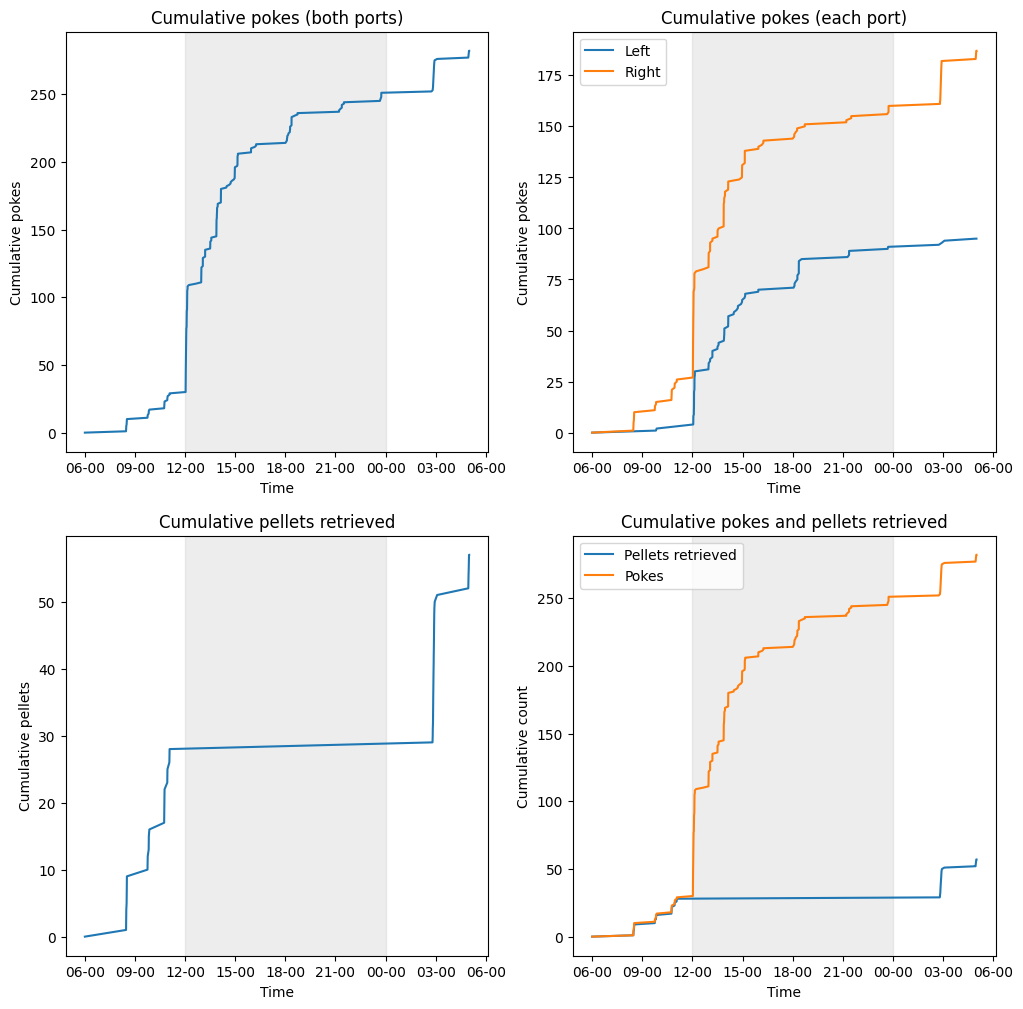

In [604]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12, 12))

# define function to shade in lights-off period
def shade_lights_off(axes):
       ylim = axes.get_ylim()
       axes.fill_between([datetime(1,1,1,12,0),datetime(1,1,2,0,0)],[ylim[0],ylim[0]],[ylim[1],ylim[1]], color='darkgray', alpha=0.2)
       axes.set_ylim(ylim)

### Subplot 1: total pokes (cumulative)
ax1.plot(pokes_cum)
ax1.set(xlabel="Time",
       ylabel="Cumulative pokes",
       title="Cumulative pokes (both ports)")
date_form = DateFormatter("%H-%M")
ax1.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax1)

### Subplot 2: L/R pokes
ax2.plot(L_pokes_cum, label = 'Left')
ax2.plot(R_pokes_cum, label = 'Right')
ax2.set(xlabel="Time",
       ylabel="Cumulative pokes",
       title="Cumulative pokes (each port)")
date_form = DateFormatter("%H-%M")
ax2.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax2)
ax2.legend()

### Subplot 3: pellets
ax3.plot(pellets_cum)
ax3.set(xlabel="Time",
       ylabel="Cumulative pellets",
       title="Cumulative pellets retrieved")
date_form = DateFormatter("%H-%M")
ax3.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax3)

### Subplot 4: pokes+pellets
ax4.plot(pellets_cum,label='Pellets retrieved')
ax4.plot(pokes_cum,label='Pokes')
ax4.set(xlabel="Time",
       ylabel="Cumulative count",
       title="Cumulative pokes and pellets retrieved")
date_form = DateFormatter("%H-%M")
ax4.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax4)
ax4.legend()

fig.savefig('FED3_pokes_pellets.png')

Plot photometry trace together with cumulative pokes and pellets

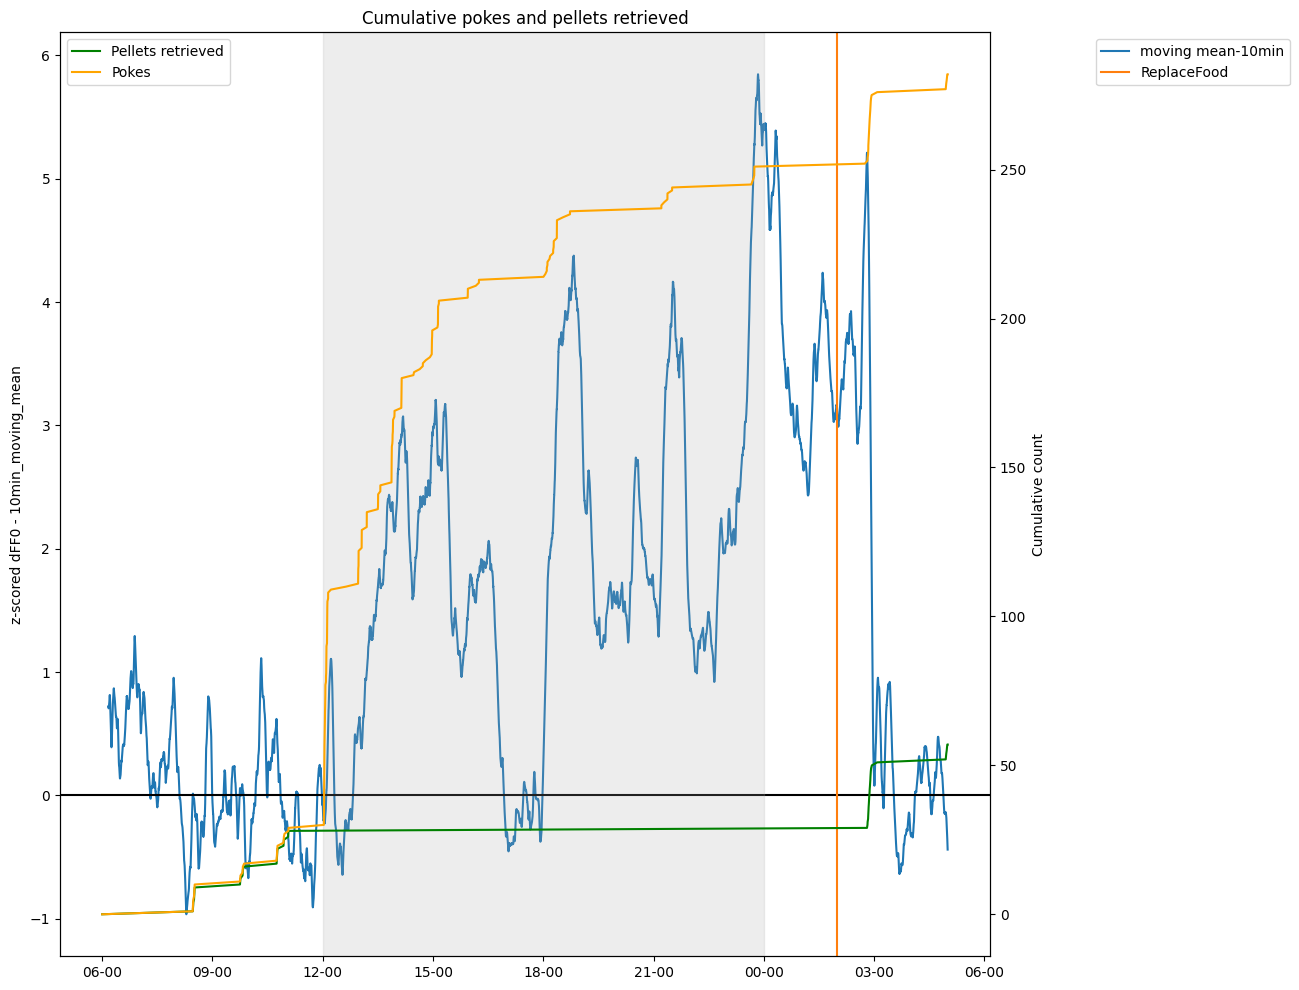

In [605]:
fig, ax1 = plt.subplots(figsize=(12, 12))

# First plot photometry data
ax1.plot(AllData['moving mean']['10'], label='moving mean-10min')
ax1.axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
ax1.set_ylabel('z-scored dFF0 - 10min_moving_mean')
date_form = DateFormatter("%H-%M")
ylim = ax1.get_ylim()
Events = AllData['Events'].loc[[i for i in AllData['Events'].index if i.hour not in [12,0]]]
# Plot vertical lines at event times
for i in list(range(len(Events))):
    ax1.plot([Events.index[i],Events.index[i]], ylim, label=Events[i][0])
ax1.set_ylim(ylim)
ax1.legend(bbox_to_anchor=(1.33, 1), loc='upper right')

# Plot behavioral data on the same axes ("twin" the axes)
ax2 = ax1.twinx()
ax2.plot(pellets_cum, label='Pellets retrieved', color='green')
ax2.plot(pokes_cum, label='Pokes', color='orange')
ax2.set(xlabel="Time",
       ylabel="Cumulative count",
       title="Cumulative pokes and pellets retrieved")
date_form = DateFormatter("%H-%M")
ax2.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax2)
ax2.legend()

fig.savefig('MM10_pokes_pellets.png')

Plot poke rate (in 10-min sliding window) together with photometry trace.

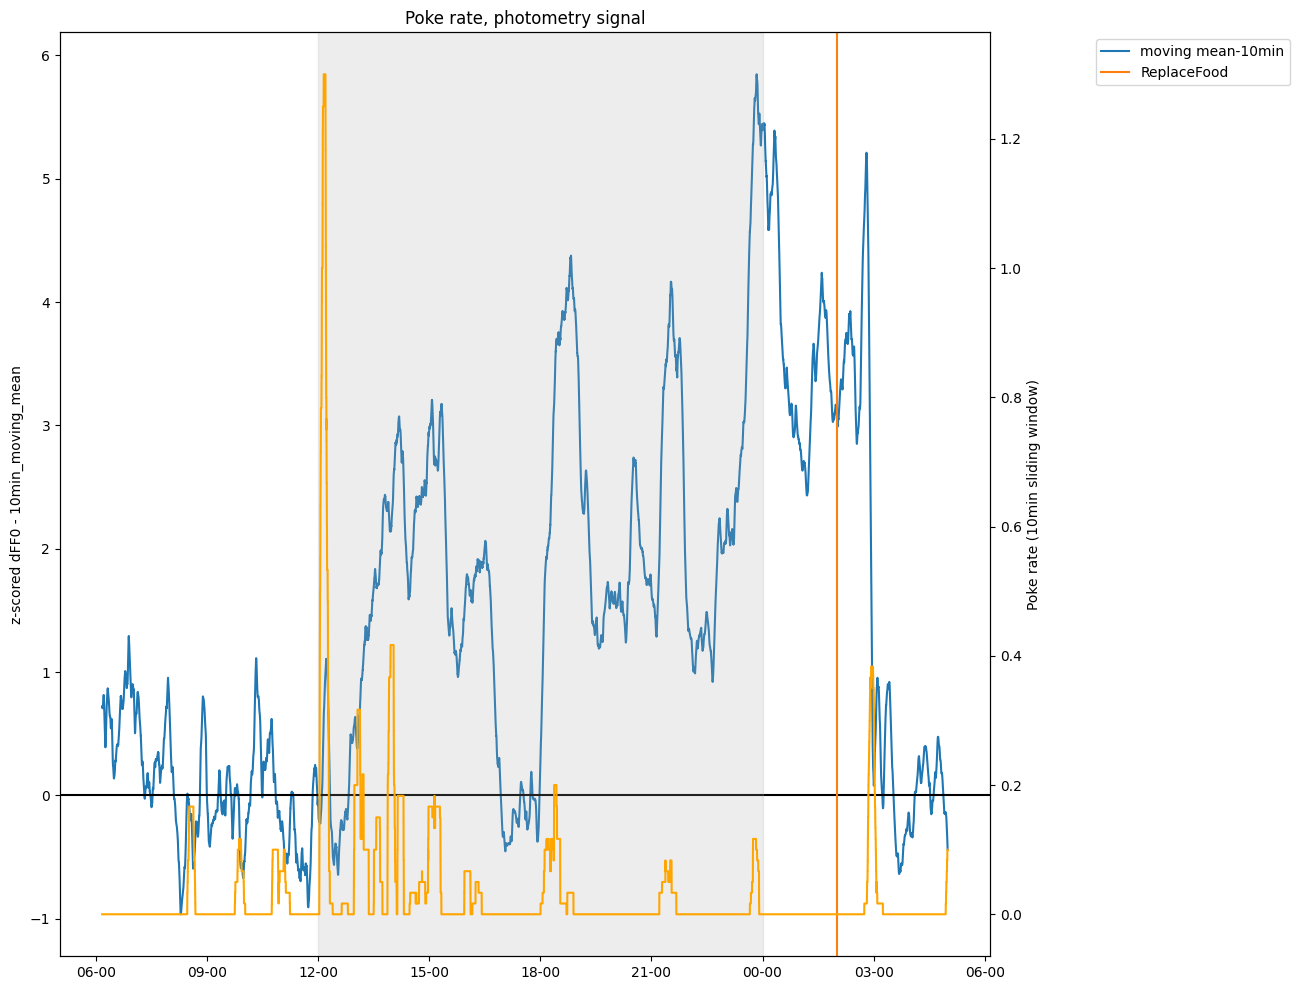

In [606]:
Timestamps = date_range(Start, End, 1, 'seconds')
Timestamps = pd.DataFrame(np.zeros(len(Timestamps)), index = Timestamps)
for i in pokes.index:
    Timestamps.loc[i] = 1
Poke_Rate = Timestamps.rolling(window = 60*10, center=False).mean()*10

fig, ax1 = plt.subplots(figsize=(12, 12))

# First plot photometry data
ax1.plot(AllData['moving mean']['10'], label='moving mean-10min')
ax1.axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
ax1.set_ylabel('z-scored dFF0 - 10min_moving_mean')
date_form = DateFormatter("%H-%M")
ylim = ax1.get_ylim()
Events = AllData['Events'].loc[[i for i in AllData['Events'].index if i.hour not in [12,0]]]
# Plot vertical lines at event times
for i in list(range(len(Events))):
    ax1.plot([Events.index[i],Events.index[i]], ylim, label=Events[i][0])
ax1.set_ylim(ylim)
ax1.legend(bbox_to_anchor=(1.33, 1), loc='upper right')

# Plot poke rate on twin axes
ax2 = ax1.twinx()
ax2.plot(Poke_Rate, label='Poke Rate', color='orange')
ax2.set(xlabel="Time",
       ylabel="Poke rate (10min sliding window)",
       title="Poke rate, photometry signal")
date_form = DateFormatter("%H-%M")
ax2.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax2)

fig.savefig('MM10_pokerate_noshading.png')
fig.savefig('MM10_pokerate_noshading.svg')

Plot inter-poke and inter-rewarded-poke intervals

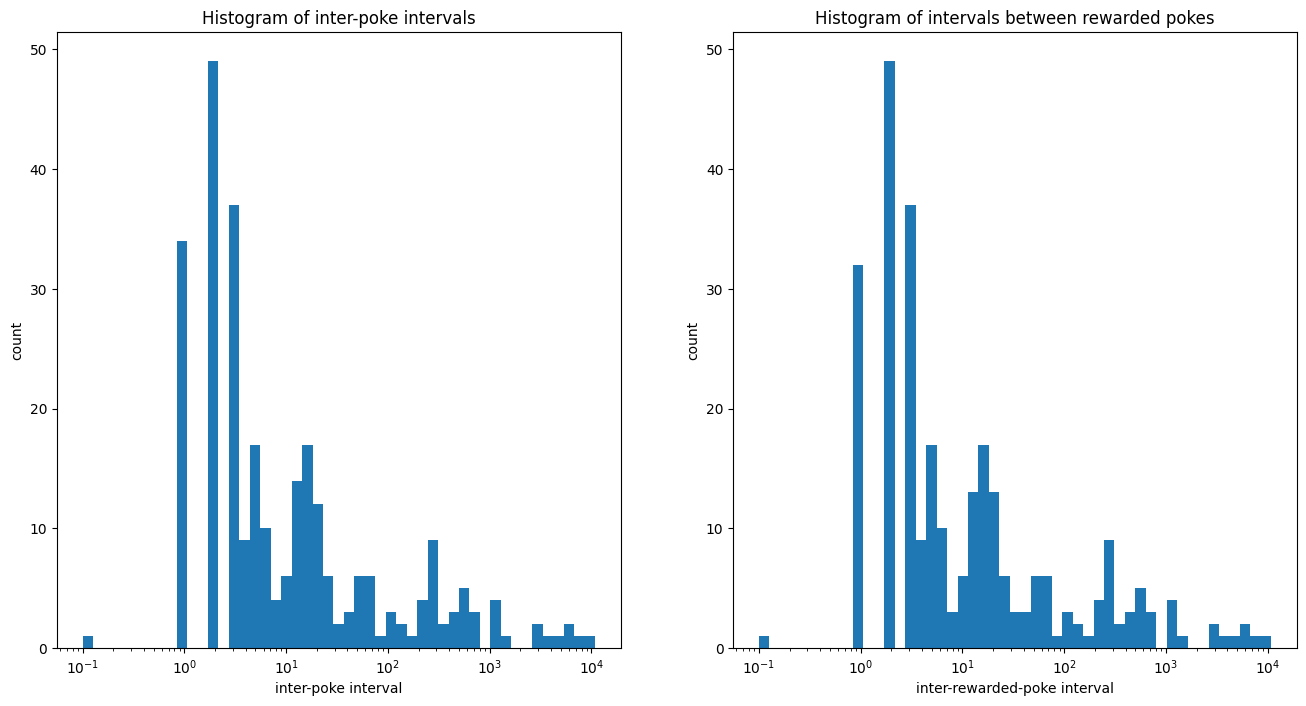

In [607]:
## when IPI/IRPI=0, add 0.1s
IPIs = []
for i in range(1,len(pokes)-1):
    ipi = (pokes.index[i] - pokes.index[i-1]).total_seconds()
    if ipi == 0:
        ipi = 0.1
    IPIs.append(ipi)
IRPIs = []
for i in range(1,len(rewarded_pokes)):
    irpi = (rewarded_pokes.index[i] - rewarded_pokes.index[i-1]).total_seconds()
    if irpi == 0:
        irpi = 0.1
    IRPIs.append(irpi)

#plot IPIs
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16, 8))
logbins = np.logspace(np.log10(0.1),np.log10(max(IPIs)),50)
ax1.hist(IPIs,bins=logbins)
ax1.set(xlabel="inter-poke interval",
       ylabel="count",
       title="Histogram of inter-poke intervals",
       xscale = 'log')

#plot IRPIs
logbins = np.logspace(np.log10(min(IRPIs)),np.log10(max(IRPIs)),50)
ax2.hist(IRPIs,bins=logbins)
ax2.set(xlabel="inter-rewarded-poke interval",
       ylabel="count",
       title="Histogram of intervals between rewarded pokes",
       xscale='log')

fig.savefig('IPI histograms.png')

Group pokes into bouts, and plot activity and poke rate as above, but now shading in poke bouts

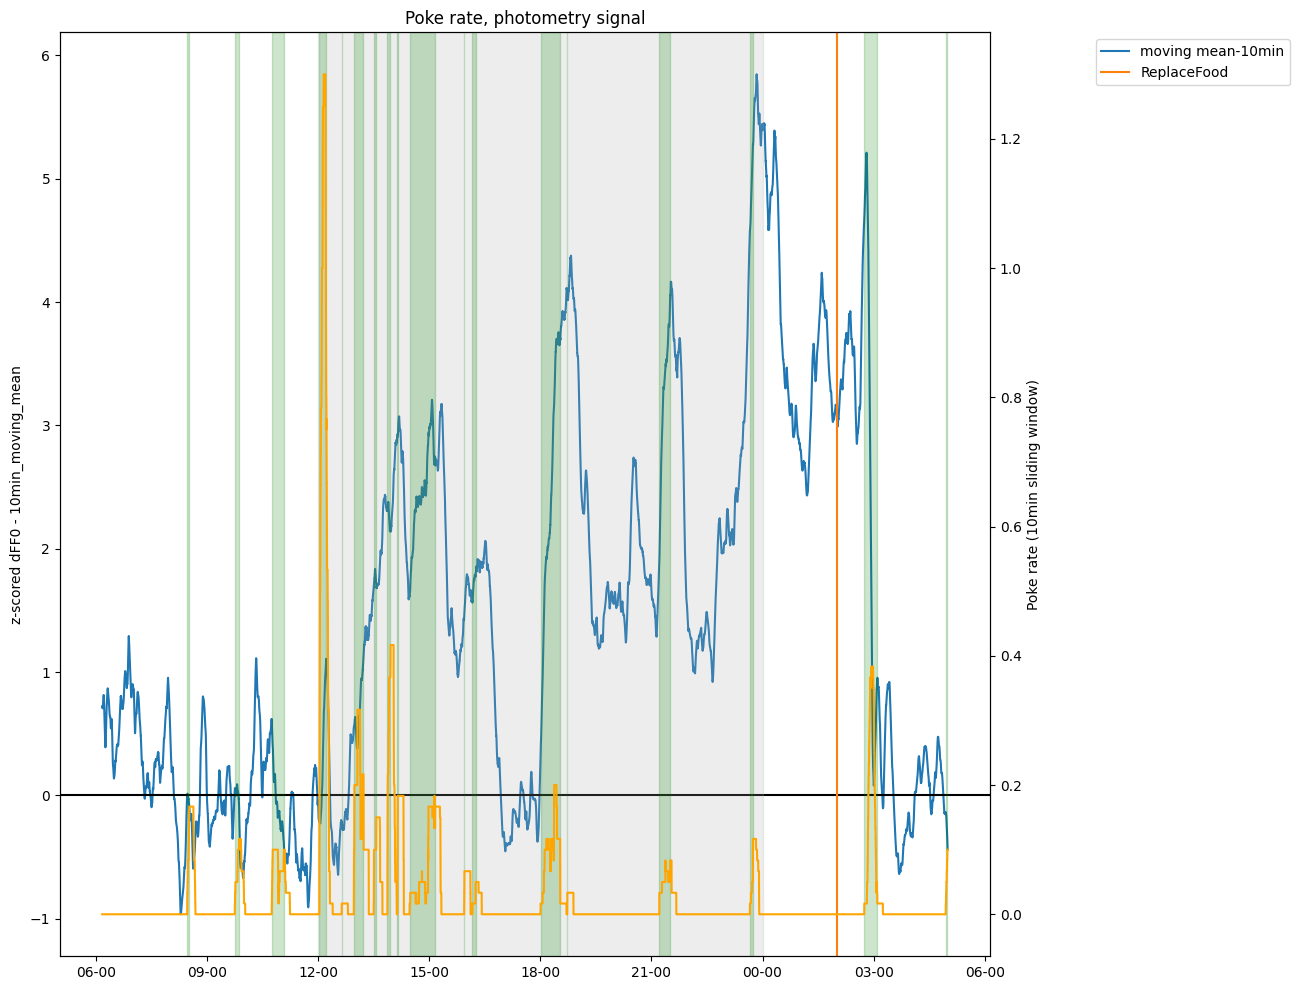

In [608]:
# Group pokes into bouts - pokes belong to the same bout if the interval between them is less than the threshold:
poke_bout_threshold = 600 # threshold in seconds
bout_starts = []
bout_starts.append(pokes.index[0])
bout_ends = []
for i in range(len(IPIs)):
    if IPIs[i] > poke_bout_threshold:
        bout_ends.append(pokes.index[i] + timedelta(seconds = round(poke_durs[i])))
        bout_starts.append(pokes.index[i+1])
bout_ends.append(pokes.index[-1])
Poke_Bouts = pd.DataFrame({'BoutStarts' : bout_starts, 'BoutEnds' : bout_ends})
del(bout_starts, bout_ends)

# Plot rolling poke rate and neural activity as above, but with poke bouts shaded.
fig, ax1 = plt.subplots(figsize=(12, 12))

# First plot photometry data
ax1.plot(AllData['moving mean']['10'], label='moving mean-10min')
ax1.axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
ax1.set_ylabel('z-scored dFF0 - 10min_moving_mean')
date_form = DateFormatter("%H-%M")
ylim = ax1.get_ylim()
Events = AllData['Events'].loc[[i for i in AllData['Events'].index if i.hour not in [12,0]]]
# Plot vertical lines at event times
for i in list(range(len(Events))):
    ax1.plot([Events.index[i],Events.index[i]], ylim, label=Events[i][0])
ax1.set_ylim(ylim)
ax1.legend(bbox_to_anchor=(1.33, 1), loc='upper right')

# Plot poke rate on twin axes
ax2 = ax1.twinx()
ax2.plot(Poke_Rate, label='Poke Rate', color='orange')
ax2.set(xlabel="Time",
       ylabel="Poke rate (10min sliding window)",
       title="Poke rate, photometry signal")
date_form = DateFormatter("%H-%M")
ax2.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax2)

# Shade poke bouts
ylim = ax2.get_ylim()

for i in range(len(Poke_Bouts['BoutStarts'])):
    ax2.fill_between([Poke_Bouts['BoutStarts'][i],Poke_Bouts['BoutEnds'][i]],
                    [ylim[0],ylim[0]],[ylim[1],ylim[1]], color='green',alpha=0.2)
ax2.set_ylim(ylim)
fig.savefig('MM10_pokerate.png')
fig.savefig('MM10_pokerate.svg')

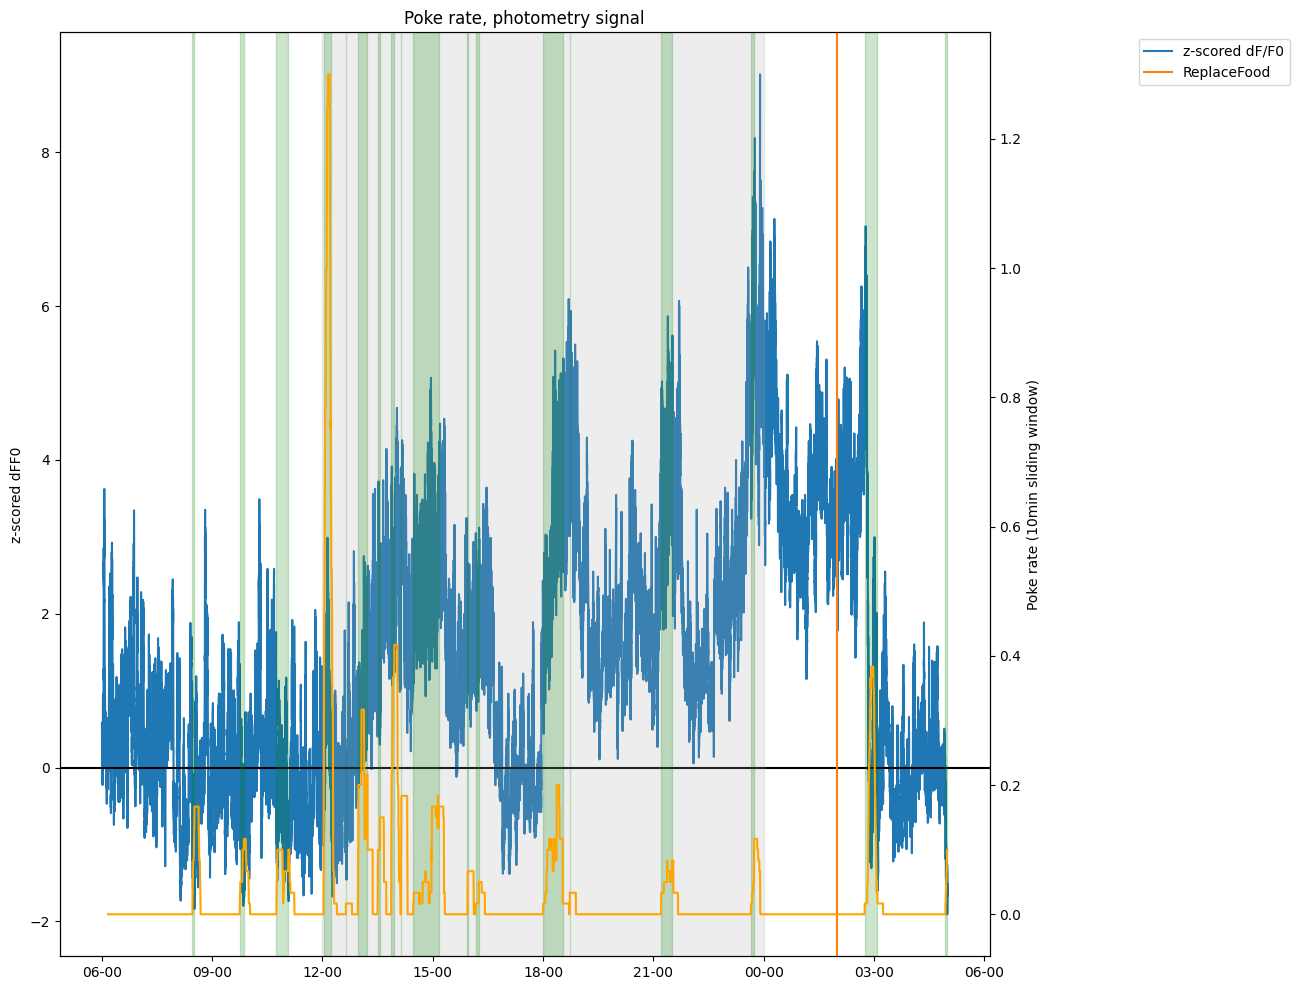

In [609]:
# same as above but with RAW Z-score trace (instead of moving mean)
fig, ax1 = plt.subplots(figsize=(12, 12))

# First plot photometry data
ax1.plot(AllData['z-score']['GCaMP'], label='z-scored dF/F0')
ax1.axhline(y=0, color='k', linestyle='-') #plot horizontal line at y=0
ax1.set_ylabel('z-scored dFF0')
date_form = DateFormatter("%H-%M")
ylim = ax1.get_ylim()
Events = AllData['Events'].loc[[i for i in AllData['Events'].index if i.hour not in [12,0]]]
# Plot vertical lines at event times
for i in list(range(len(Events))):
    ax1.plot([Events.index[i],Events.index[i]], ylim, label=Events[i][0])
ax1.set_ylim(ylim)
ax1.legend(bbox_to_anchor=(1.33, 1), loc='upper right')

# Plot poke rate on twin axes
ax2 = ax1.twinx()
ax2.plot(Poke_Rate, label='Poke Rate', color='orange')
ax2.set(xlabel="Time",
       ylabel="Poke rate (10min sliding window)",
       title="Poke rate, photometry signal")
date_form = DateFormatter("%H-%M")
ax2.xaxis.set_major_formatter(date_form)
#and shade in lights-off period:
shade_lights_off(ax2)

# Shade poke bouts
ylim = ax2.get_ylim()

for i in range(len(Poke_Bouts['BoutStarts'])):
    ax2.fill_between([Poke_Bouts['BoutStarts'][i],Poke_Bouts['BoutEnds'][i]],
                    [ylim[0],ylim[0]],[ylim[1],ylim[1]], color='green',alpha=0.2)
ax2.set_ylim(ylim)

fig.savefig('raw_zscore_pokerate.png')

Plot neural activity aligned to start and end of poke bouts:

1) heatmap, where each row is one poke bout

2) mean activity over poke bouts

In [610]:
################
# define the time before and after the start/end of each poke bout to be plotted (in minutes)
PreBoutTime = 20
PostBoutTime = 12
################

PreBoutTime = PreBoutTime*60
PostBoutTime = PostBoutTime*60
bout_indices = np.arange(0-PreBoutTime, 1+PostBoutTime, AllData['DownSamplingRate'])

Poke_Bout_Aligned = {}
Poke_Bout_Aligned['raw_Starts'] = pd.DataFrame()
Poke_Bout_Aligned['MM5_Starts'] = pd.DataFrame()

End_Time = AllData['z-score']['GCaMP'].index[-1]
Start_Time = AllData['z-score']['GCaMP'].index[0]

# Loop through poke bouts
for i in Poke_Bouts['BoutStarts']:
    # Clip if the window would go past end of recording
    if i+timedelta(seconds = PostBoutTime) > End_Time:
        # clip the range of samples to take up to the end of the recording
        Photom_Clip = date_range(i-timedelta(seconds=PreBoutTime), End_Time, AllData['DownSamplingRate'], 'seconds')
        # create a series of nans to fill the remaining time points (after end of recording)
        ind = date_range(End_Time+timedelta(seconds=AllData['DownSamplingRate']),i+timedelta(seconds=PostBoutTime),
                            AllData['DownSamplingRate'], 'seconds')
        b = pd.Series(np.full([1, len(ind)], np.nan).tolist()[0], index = ind)
        # combine with neural data
        To_Add = pd.concat([AllData['Raw_DS']['GCaMP'][Photom_Clip],b], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        # add this bout to dataframe
        Poke_Bout_Aligned['raw_Starts'] = pd.concat([Poke_Bout_Aligned['raw_Starts'],To_Add], axis=1)
        # same for moving-mean (5 minute window)
        To_Add = pd.concat([AllData['moving mean']['5'][Photom_Clip],b], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['MM5_Starts'] = pd.concat([Poke_Bout_Aligned['MM5_Starts'],To_Add], axis=1)

    # Clip if the window would start before the beginning of the recording
    elif i-timedelta(seconds=PreBoutTime) < Start_Time:
        # clip the range of samples to take from the beginning of the recording
        Photom_Clip = date_range(Start_Time, i+timedelta(seconds=PostBoutTime), AllData['DownSamplingRate'], 'seconds')
        # create a series of nans to fill the remaining time points (after end of recording)
        ind = date_range(i-timedelta(seconds=PreBoutTime),Start_Time-timedelta(seconds=AllData['DownSamplingRate']),
                            AllData['DownSamplingRate'], 'seconds')
        b = pd.Series(np.full([1, len(ind)], np.nan).tolist()[0], index = ind)
        # combine with neural data
        To_Add = pd.concat([b,AllData['Raw_DS']['GCaMP'][Photom_Clip]], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        # add this bout to dataframe
        Poke_Bout_Aligned['raw_Starts'] = pd.concat([Poke_Bout_Aligned['raw_Starts'],To_Add], axis=1)
        # same for moving-mean (5 minute window)
        To_Add = pd.concat([b,AllData['moving mean']['5'][Photom_Clip]], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['MM5_Starts'] = pd.concat([Poke_Bout_Aligned['MM5_Starts'],To_Add], axis=1)

    else:
        Photom_Clip = date_range(i-timedelta(seconds=PreBoutTime), i+timedelta(seconds=PostBoutTime), AllData['DownSamplingRate'], 'seconds')
        To_Add = AllData['Raw_DS']['GCaMP'][Photom_Clip]
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['raw_Starts'] = pd.concat([Poke_Bout_Aligned['raw_Starts'],To_Add], axis=1)
        To_Add = AllData['moving mean']['5'][Photom_Clip]
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['MM5_Starts'] = pd.concat([Poke_Bout_Aligned['MM5_Starts'],To_Add], axis=1)

# Same for poke bout ends
Poke_Bout_Aligned['raw_Ends'] = pd.DataFrame()
Poke_Bout_Aligned['MM5_Ends'] = pd.DataFrame()

for i in Poke_Bouts['BoutEnds']:
    # Clip if the window would go past end of recording
    if i+timedelta(seconds = PostBoutTime) > End_Time:
        # clip the range of samples to take up to the end of the recording
        Photom_Clip = date_range(i-timedelta(seconds=PreBoutTime), End_Time, AllData['DownSamplingRate'], 'seconds')
        # create a series of nans to fill the remaining time points (after end of recording)
        ind = date_range(End_Time+timedelta(seconds=AllData['DownSamplingRate']),i+timedelta(seconds=PostBoutTime),
                            AllData['DownSamplingRate'], 'seconds')
        b = pd.Series(np.full([1, len(ind)], np.nan).tolist()[0], index = ind)
        # combine with neural data
        To_Add = pd.concat([AllData['Raw_DS']['GCaMP'][Photom_Clip],b], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        # add this bout to dataframe
        Poke_Bout_Aligned['raw_Ends'] = pd.concat([Poke_Bout_Aligned['raw_Ends'],To_Add], axis=1)
        # same for moving-mean (5 minute window)
        To_Add = pd.concat([AllData['moving mean']['5'][Photom_Clip],b], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['MM5_Ends'] = pd.concat([Poke_Bout_Aligned['MM5_Ends'],To_Add], axis=1)

    # Clip if the window would start before the beginning of the recording
    elif i-timedelta(seconds=PreBoutTime) < Start_Time:
        # clip the range of samples to take from the beginning of the recording
        Photom_Clip = date_range(Start_Time, i+timedelta(seconds=PostBoutTime), AllData['DownSamplingRate'], 'seconds')
        # create a series of nans to fill the remaining time points (after end of recording)
        ind = date_range(i-timedelta(seconds=PreBoutTime),Start_Time-timedelta(seconds=AllData['DownSamplingRate']),
                            AllData['DownSamplingRate'], 'seconds')
        b = pd.Series(np.full([1, len(ind)], np.nan).tolist()[0], index = ind)
        # combine with neural data
        To_Add = pd.concat([b,AllData['Raw_DS']['GCaMP'][Photom_Clip]], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        # add this bout to dataframe
        Poke_Bout_Aligned['raw_Ends'] = pd.concat([Poke_Bout_Aligned['raw_Ends'],To_Add], axis=1)
        # same for moving-mean (5 minute window)
        To_Add = pd.concat([b,AllData['moving mean']['5'][Photom_Clip]], axis=0)
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['MM5_Ends'] = pd.concat([Poke_Bout_Aligned['MM5_Ends'],To_Add], axis=1)

    else:
        Photom_Clip = date_range(i-timedelta(seconds=PreBoutTime), i+timedelta(seconds=PostBoutTime), AllData['DownSamplingRate'], 'seconds')
        To_Add = AllData['Raw_DS']['GCaMP'][Photom_Clip]
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['raw_Ends'] = pd.concat([Poke_Bout_Aligned['raw_Ends'],To_Add], axis=1)
        To_Add = AllData['moving mean']['5'][Photom_Clip]
        To_Add.index = bout_indices
        To_Add.name = i
        Poke_Bout_Aligned['MM5_Ends'] = pd.concat([Poke_Bout_Aligned['MM5_Ends'],To_Add], axis=1)

# Normalize activity for each poke bout start/end to activity in the pre-start/end period
Trace_Types = ['raw_Starts','raw_Ends','MM5_Starts','MM5_Ends']

for trace_type in Trace_Types:
    Poke_Bout_Aligned['Norm_'+trace_type] = pd.DataFrame()
    F0 = Poke_Bout_Aligned[trace_type].loc[0-PreBoutTime:-1].mean(axis=0)
    Poke_Bout_Aligned['Norm_'+trace_type] = (Poke_Bout_Aligned[trace_type] - F0) / F0

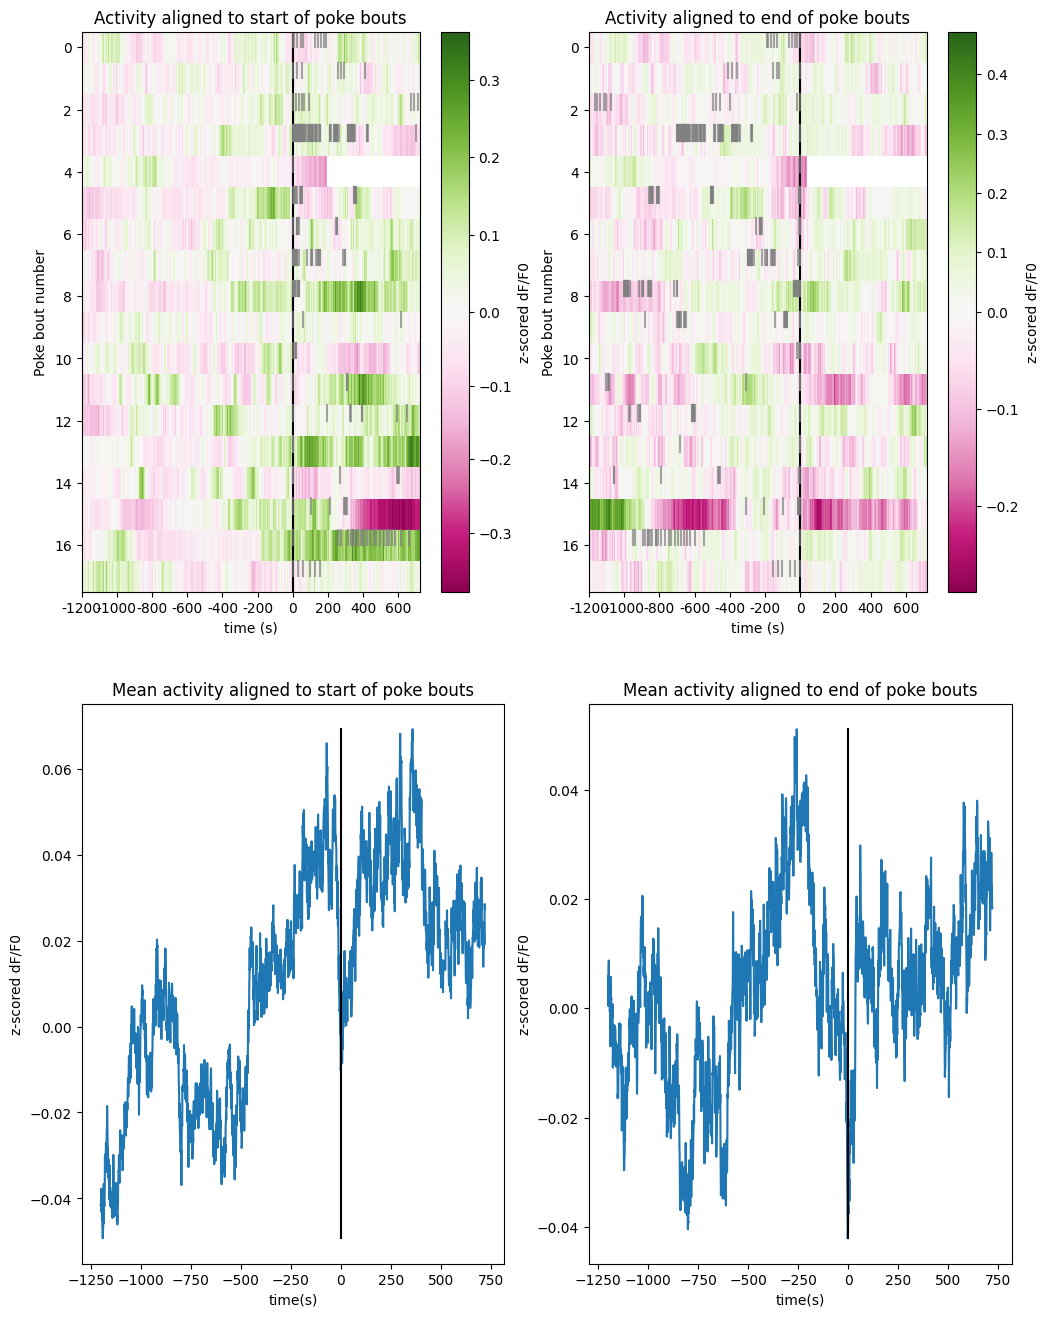

In [611]:
# Plot heatmap
trace_type = 'Norm_raw'
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,16))
# Create colormap centered around 0
divnorm = colors.TwoSlopeNorm(vmin=Poke_Bout_Aligned[trace_type+'_Starts'].min().min(), vcenter=0., 
                              vmax=Poke_Bout_Aligned[trace_type+'_Starts'].max().max())
divnorm2 = colors.TwoSlopeNorm(vmin=Poke_Bout_Aligned[trace_type+'_Ends'].min().min(), vcenter=0., 
                              vmax=Poke_Bout_Aligned[trace_type+'_Ends'].max().max())
# Sort by bout duration
# Get bout durations
Poke_Bouts['BoutDurs'] = [i.total_seconds() for i in Poke_Bouts['BoutEnds'] - Poke_Bouts['BoutStarts']]
# sort indices by duration
inds = np.array(Poke_Bouts['BoutDurs']).argsort()
# sort start times, end times and durations
Starts = Poke_Bouts['BoutStarts'][inds]
Durs = Poke_Bouts['BoutDurs'][inds]
Ends = Poke_Bouts['BoutEnds'][inds]

# plot as heatmap - one for traces aligned to bout start, and one for bout end
im = ax1.imshow(Poke_Bout_Aligned[trace_type+'_Starts'][Starts].transpose(), aspect='auto', interpolation='none',
                norm=divnorm, cmap='PiYG')
im2 = ax2.imshow(Poke_Bout_Aligned[trace_type+'_Ends'][Ends].transpose(), aspect='auto', interpolation='none',
                 norm=divnorm2, cmap='PiYG')
# add x ticks, axis labels and title
ax1.set_xticks(range(0,len(Poke_Bout_Aligned[trace_type+'_Starts'].index),200))
ax2.set_xticks(range(0,len(Poke_Bout_Aligned[trace_type+'_Ends'].index),200))
ax1.set_xticklabels([str(i) for i in list(range(Poke_Bout_Aligned[trace_type+'_Starts'].index[0],
                                                Poke_Bout_Aligned[trace_type+'_Starts'].index[-1],200))])
ax2.set_xticklabels([str(i) for i in list(range(Poke_Bout_Aligned[trace_type+'_Ends'].index[0],
                                                Poke_Bout_Aligned[trace_type+'_Ends'].index[-1],200))])
ax1.set(xlabel='time (s)',
        ylabel='Poke bout number',
        title='Activity aligned to start of poke bouts')
ax2.set(xlabel='time (s)',
        ylabel='Poke bout number',
        title='Activity aligned to end of poke bouts')
# plot vertical line at t=0
ax1.plot([0-Poke_Bout_Aligned[trace_type+'_Starts'].index[0], 0-Poke_Bout_Aligned[trace_type+'_Starts'].index[0]],
         [-0.5,len(Poke_Bout_Aligned[trace_type+'_Starts'].columns)-0.5], color='black')
ax2.plot([0-Poke_Bout_Aligned[trace_type+'_Ends'].index[0], 0-Poke_Bout_Aligned[trace_type+'_Ends'].index[0]],
         [-0.5,len(Poke_Bout_Aligned[trace_type+'_Ends'].columns)-0.5], color='black')

# plot tick for each poke during bout - loop through bouts and get poke times in this bout
for boutn in range(len(Starts)):
    pokes_in_bout = [j for j in list(pokes.index) if j>=Starts[boutn] and j<Starts[boutn]+timedelta(seconds=PostBoutTime)]
    for j in pokes_in_bout:
        rel_poke_time = (j-Starts[boutn]).total_seconds()
        ax1.plot([0-Poke_Bout_Aligned[trace_type+'_Starts'].index[0]+rel_poke_time, 0-Poke_Bout_Aligned[trace_type+'_Starts'].index[0]+rel_poke_time],
                 [boutn-0.5, boutn], color='gray', alpha=0.7)

for boutn in range(len(Ends)):
    pokes_in_bout = [j for j in list(pokes.index) if j>Ends[boutn]-timedelta(seconds=PreBoutTime) and j<=Ends[boutn]]
    for j in pokes_in_bout:
        rel_poke_time = (j-Ends[boutn]).total_seconds()
        ax2.plot([0-Poke_Bout_Aligned[trace_type+'_Ends'].index[0]+rel_poke_time, 0-Poke_Bout_Aligned[trace_type+'_Ends'].index[0]+rel_poke_time],
                 [boutn-0.5, boutn], color='gray', alpha=0.7)
        
# add colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar.set_label('z-scored dF/F0')
cbar2.set_label('z-scored dF/F0')
fig.tight_layout

# plot mean over bouts
mean_start = Poke_Bout_Aligned[trace_type+'_Starts'].mean(axis=1)
ax3.plot(mean_start)
ax3.set(xlabel="time(s)",
       ylabel="z-scored dF/F0",
       title="Mean activity aligned to start of poke bouts")
ax3.plot([0,0],[min(mean_start),max(mean_start)],color='black')

mean_end = Poke_Bout_Aligned[trace_type+'_Ends'].mean(axis=1)
ax4.plot(mean_end)
ax4.set(xlabel="time(s)",
       ylabel="z-scored dF/F0",
       title="Mean activity aligned to end of poke bouts")
ax4.plot([0,0],[min(mean_end),max(mean_end)],color='black')

fig.savefig('PokeBout-aligned activity - '+trace_type+'.png')

Plot neural activity aligned to rewarded pokes (i.e. pokes that are followed by pellet delivery):

1) heatmap, where each row is one poke

2) mean activity over pokes

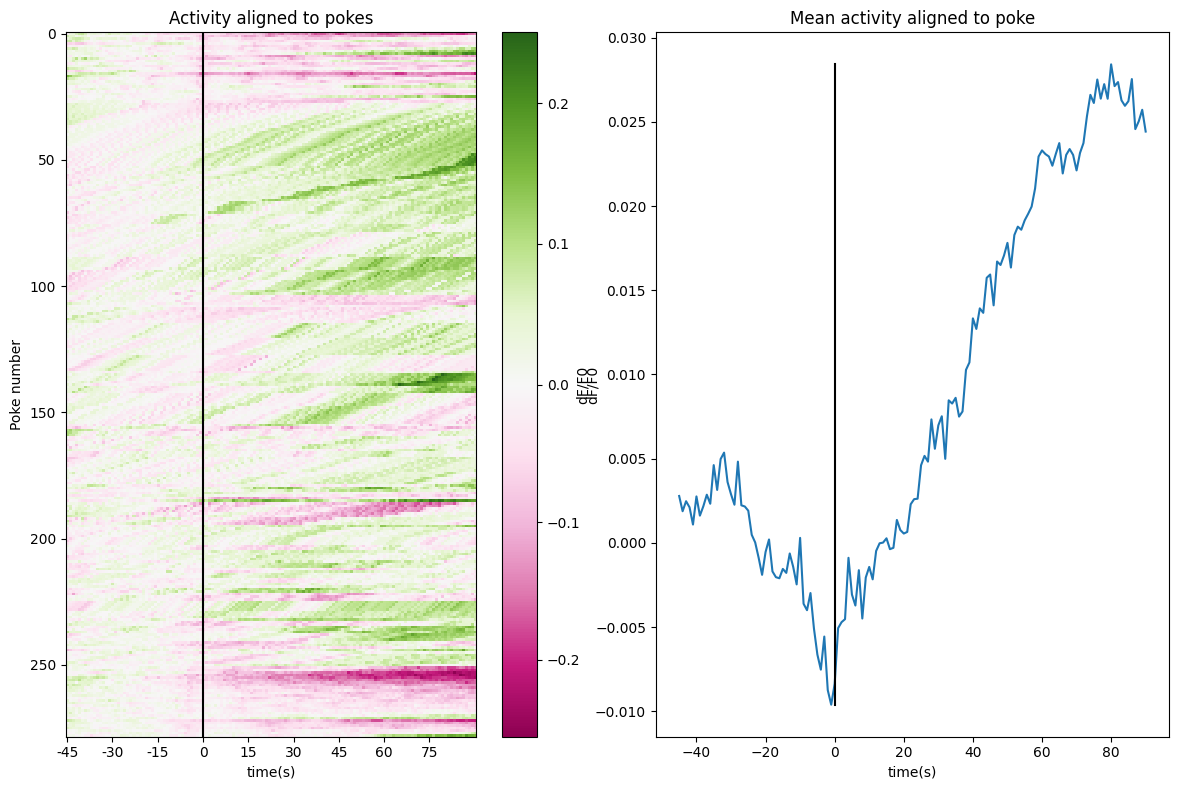

In [612]:
## Define time before and after each poke to plot
PrePokeTime = 45 #in seconds
PostPokeTime = 90 #in seconds

poke_activity = {}
poke_activity['raw'] = pd.DataFrame()
poke_activity['dFF0'] = pd.DataFrame()

# loop through rewarded pokes
n=-1
poke_ind = list(range(0-PrePokeTime,1+PostPokeTime,AllData['DownSamplingRate']))
for i in rewarded_pokes.index:
    if i - timedelta(seconds=PrePokeTime) > AllData['Raw_DS']['GCaMP'].index[0] and i + timedelta(seconds=PostPokeTime) <= AllData['Raw_DS']['GCaMP'].index[-1]:
       n=n+1
       # get time points relative to this poke
       PhotomClip = date_range(i-timedelta(seconds=PrePokeTime), i+timedelta(seconds=PostPokeTime), AllData['DownSamplingRate'], 'seconds')
       Clip = AllData['Raw_DS']['GCaMP'][PhotomClip]
       Clip.name = i
       Clip.index = poke_ind
       poke_activity['raw'] = pd.concat([poke_activity['raw'], Clip], axis=1)
       # calculate activity relative to pre-poke period
       Clip_F0 = Clip[np.arange(0-PrePokeTime,-1,AllData['DownSamplingRate'])].mean(axis=0)
       poke_activity['dFF0'] = pd.concat([poke_activity['dFF0'],(Clip-Clip_F0)/Clip_F0],axis=1)

# plot heatmap using pre-poke-normalized activity (dF/F0)
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,8))
divnorm = colors.TwoSlopeNorm(vmin=poke_activity['dFF0'].min().min(), vcenter=0., vmax=poke_activity['dFF0'].max().max())
im = ax1.imshow(poke_activity['dFF0'].transpose(), aspect='auto', interpolation='none', norm=divnorm, cmap='PiYG')
# add x ticks, labels, title
ax1.set_xticks(range(0,len(poke_activity['dFF0'].index)-1,15))
ax1.set_xticklabels([str(i) for i in list(range(poke_activity['dFF0'].index[0],poke_activity['dFF0'].index[-1],15))])
ax1.set(xlabel="time(s)",
       ylabel="Poke number",
       title="Activity aligned to pokes")
# add line at t=0
ax1.plot([0-poke_activity['dFF0'].index[0],0-poke_activity['dFF0'].index[0]],[-0.5,len(poke_activity['dFF0'].columns)-0.5],color='black')
# colorbar
cbar = plt.colorbar(im,ax=ax1)
cbar.set_label('dF/F0')
fig.tight_layout()

# also plot mean activity over pokes
mean_poke_activity = np.mean(poke_activity['dFF0'],axis=1)
ax2.plot(mean_poke_activity)
ax2.plot([0,0],[min(mean_poke_activity),max(mean_poke_activity)],color='black')
ax2.set(xlabel="time(s)",
       ylabel="dF/F0",
       title="Mean activity aligned to poke")

fig.savefig('Poke-aligned activity.png')

For some recordings, pokes are only rewarded at specific times of day. For that reason, let's divide pokes into three groups:
1) start to ZT12
2) ZT12-ZT2
3) ZT2 to end

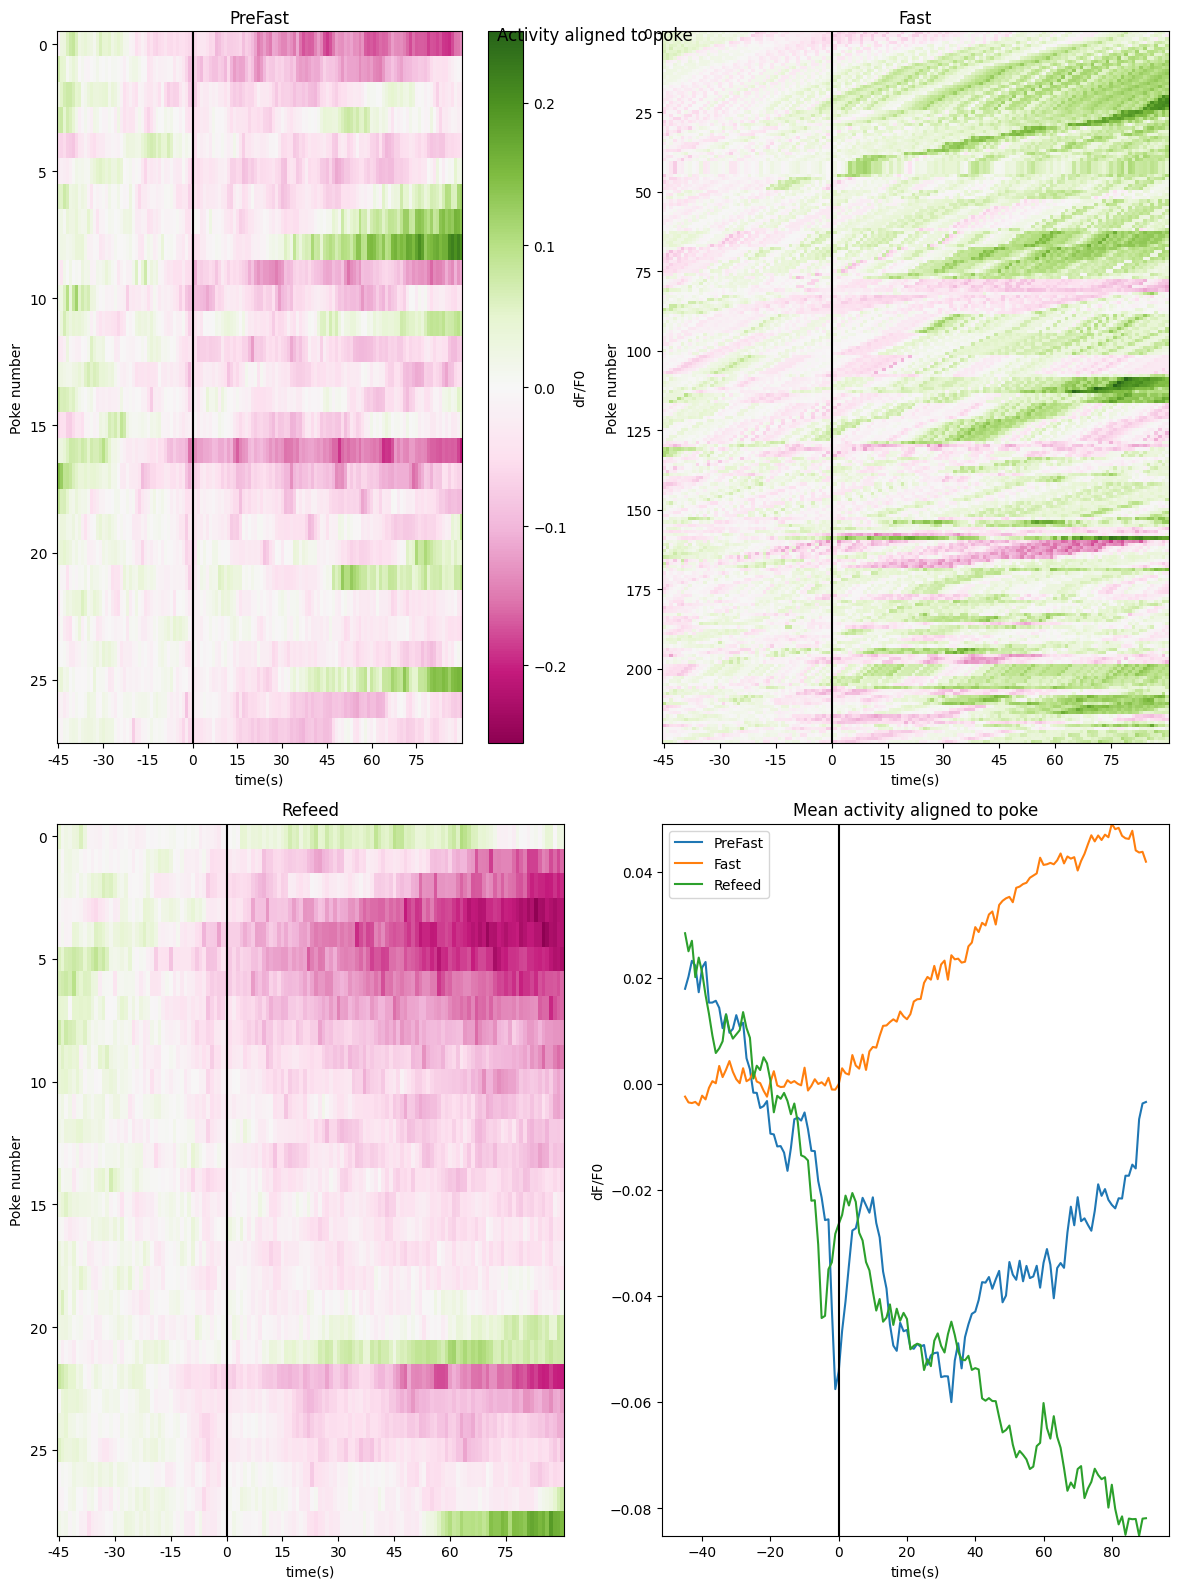

In [613]:
# name the periods depending on the condition
if AllData['Condition'] == '6pm-8am fast' or '6-8 fast Saline' or '6-8 fast CNO':
    Period1 = 'PreFast'
    Period2 = 'Fast'
    Period3 = 'Refeed'
elif AllData['Condition'] == 'fed':
    Period1 = 'ZT6-ZT12'
    Period2 = 'ZT12-ZT2'
    Period3 = 'ZT2-ZT5'
elif AllData['Condition'] == 'FR1 6-8 fast' or 'FR8 6-8 fast':
    Period1 = 'PreFast'
    Period2 = 'Fast'
    Period3 = 'Refeed'
elif AllData['Condition'] == 'FR1 fed' or 'FR8 fed':
    Period1 = 'ZT6-ZT12'
    Period2 = 'ZT12-ZT2'
    Period3 = 'ZT2-ZT5'

# initialize dataframes
poke_activity['dFF0_' + Period1] = pd.DataFrame()
poke_activity['dFF0_' + Period2] = pd.DataFrame()
poke_activity['dFF0_' + Period3] = pd.DataFrame()

# loop through poke-aligned activity traces, and add to corresponding dataframe given period
for i in poke_activity['dFF0'].columns:
    # adjust to offset (i.e. divide periods based on FED internal clock, not "real time")
    FEDTime = i + FED_clock_offset
    if FEDTime.day == 1:
        if FEDTime.hour<12:
            poke_activity['dFF0_' + Period1] = pd.concat([poke_activity['dFF0_' + Period1],poke_activity['dFF0'][i]], axis=1)
        elif FEDTime.hour>=12:
            poke_activity['dFF0_' + Period2] = pd.concat([poke_activity['dFF0_' + Period2],poke_activity['dFF0'][i]], axis=1)
    elif FEDTime.day == 2:
        if FEDTime.hour<2:
            poke_activity['dFF0_' + Period2] = pd.concat([poke_activity['dFF0_' + Period2],poke_activity['dFF0'][i]], axis=1)
        elif FEDTime.hour >=2:
            poke_activity['dFF0_' + Period3] = pd.concat([poke_activity['dFF0_' + Period3],poke_activity['dFF0'][i]], axis=1)
                                
# plot separate heatmap of activity aligned to each poke for each period
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(12,16))
# use same colormap for all three heatmaps
divnorm = colors.TwoSlopeNorm(vmin=poke_activity['dFF0'].min().min(), vcenter=0., vmax=poke_activity['dFF0'].max().max())

Periods = [Period1,Period2,Period3]
axes = [ax1,ax2,ax3]

# plot heatmaps, add axis ticks, labels and titles
for n in [0,1,2]:
    im = axes[n].imshow(poke_activity['dFF0_' + Periods[n]].transpose(),aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    axes[n].set_xticks(range(0,len(poke_activity['dFF0_' + Periods[n]].index)-1,15))
    axes[n].set_xticklabels([str(i) for i in list(range(poke_activity['dFF0_' + Periods[n]].index[0],poke_activity['dFF0_' + Periods[n]].index[-1],15))])
    axes[n].set(xlabel="time(s)",
       ylabel="Poke number",
       title=Periods[n])
    axes[n].plot([0-poke_activity['dFF0_' + Periods[n]].index[0],0-poke_activity['dFF0_' + Periods[n]].index[0]],
                 [-0.5,len(poke_activity['dFF0_' + Periods[n]].columns)-0.5],color='black')

cbar = plt.colorbar(im,ax=ax1)
cbar.set_label('dF/F0')
fig.tight_layout()

# plot mean activity over pokes for each period
MeanPokeActivity = pd.DataFrame()
MeanPokeActivity[Period1] = np.mean(poke_activity['dFF0_'+Period1],axis=1)
MeanPokeActivity[Period2] = np.mean(poke_activity['dFF0_'+Period2],axis=1)
MeanPokeActivity[Period3] = np.mean(poke_activity['dFF0_'+Period3],axis=1)

ax4.plot(MeanPokeActivity)
ax4.plot([0,0],[MeanPokeActivity.min().min(),MeanPokeActivity.max().max()],color='black')
ax4.set_ylim([MeanPokeActivity.min().min(),MeanPokeActivity.max().max()])
ax4.set(xlabel="time(s)",
       ylabel="dF/F0",
       title="Mean activity aligned to poke")
ax4.legend(MeanPokeActivity.columns)

fig.suptitle('Activity aligned to poke')
fig.savefig('Poke-aligned activity by period.png')    


Same for poke bouts

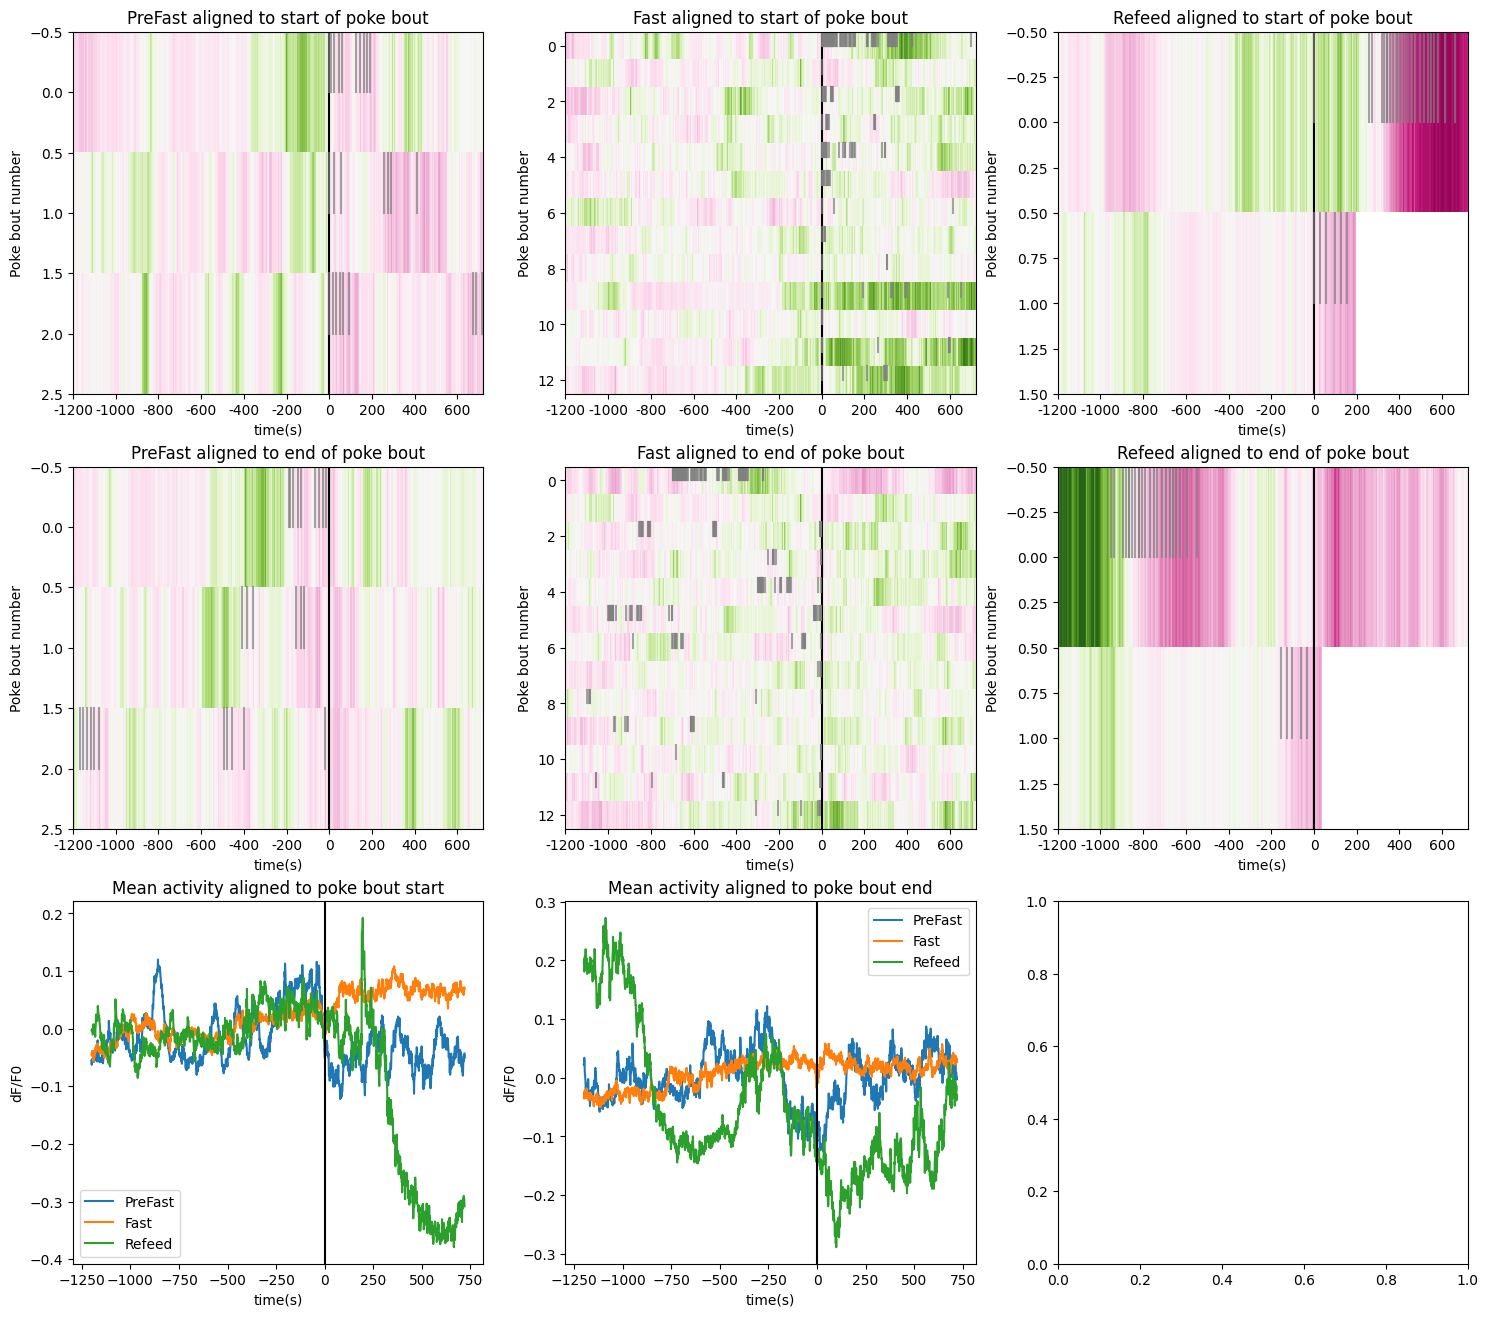

In [614]:
# For each poke bout, determine which period it BEGINS in
bout_periods = []
for i in Poke_Bout_Aligned['Norm_raw_Starts'].columns:
    FEDTime = i + FED_clock_offset
    if FEDTime.day == 1:
        if FEDTime.hour<12:
            bout_periods.append(Period1)
        elif FEDTime.hour>=12:
            bout_periods.append(Period2)
    elif FEDTime.day == 2:
        if FEDTime.hour<2:
            bout_periods.append(Period2)
        elif FEDTime.hour >=2:
            bout_periods.append(Period3)

# For each data type, add an extra row to column (multiindex) with name of period
for k in Poke_Bout_Aligned.keys():
    Poke_Bout_Aligned[k].columns = [np.array(Poke_Bout_Aligned[k].columns), np.array(bout_periods)]

# Create figure
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(18,16))
# Create scale for normalization
divnorm=colors.TwoSlopeNorm(vmin=Poke_Bout_Aligned['Norm_raw_Starts'].min().min(), vcenter=0., 
                            vmax=Poke_Bout_Aligned['Norm_raw_Starts'].max().max())

Periods = [Period1,Period2,Period3]
start_axes = [ax1,ax2,ax3]
end_axes = [ax4,ax5,ax6]

# Loop through periods and create heatmap
for n in [0,1,2]:
    # Get start and end times for bouts beginning in this period
    starts = Poke_Bout_Aligned['Norm_raw_Starts'].xs(Periods[n], level=1, axis=1)
    ends = Poke_Bout_Aligned['Norm_raw_Ends'].xs(Periods[n], level=1, axis=1)
    # Create heatmaps
    im = start_axes[n].imshow(starts.transpose(),
                            aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    im = end_axes[n].imshow(ends.transpose(),
                            aspect='auto',interpolation='none',norm=divnorm,cmap='PiYG')
    # set axis properties
    start_axes[n].set_xticks(range(0,len(Poke_Bout_Aligned['Norm_raw_Starts'].index)-1,200))
    start_axes[n].set_xticklabels([str(i) for i in list(range(Poke_Bout_Aligned['Norm_raw_Starts'].index[0],
                                                              Poke_Bout_Aligned['Norm_raw_Starts'].index[-1],200))])
    start_axes[n].set(xlabel="time(s)",
                ylabel="Poke bout number",
                title=Periods[n] + " aligned to start of poke bout")
    end_axes[n].set_xticks(range(0,len(Poke_Bout_Aligned['Norm_raw_Ends'].index)-1,200))
    end_axes[n].set_xticklabels([str(i) for i in list(range(Poke_Bout_Aligned['Norm_raw_Ends'].index[0],
                                                              Poke_Bout_Aligned['Norm_raw_Ends'].index[-1],200))])
    end_axes[n].set(xlabel="time(s)",
                ylabel="Poke bout number",
                title=Periods[n] + " aligned to end of poke bout")
    
    # plot line at t=0 (time of bout start/end)
    start_axes[n].plot([0-Poke_Bout_Aligned['Norm_raw_Starts'].index[0],0-Poke_Bout_Aligned['Norm_raw_Starts'].index[0]],
                 [-0.5,len(starts.columns)-0.5],color='black')
    end_axes[n].plot([0-Poke_Bout_Aligned['Norm_raw_Ends'].index[0],0-Poke_Bout_Aligned['Norm_raw_Ends'].index[0]],
                 [-0.5,len(ends.columns)-0.5],color='black')

    # plot tick for each poke during bout
    boutn = -1
    # loop through bout starts
    for i in starts.columns:
        boutn = boutn+1
        # take pokes that happen between bout start and PostBoutTime
        PokesInBout = [j for j in list(pokes.index) if j>=i and j<i+timedelta(seconds=PostBoutTime)]
        # plot tick
        for j in PokesInBout:
            RelPokeTime = j-i
            RelPokeTime = RelPokeTime.total_seconds()
            start_axes[n].plot([0-Poke_Bout_Aligned['Norm_raw_Starts'].index[0]+RelPokeTime,
                                0-Poke_Bout_Aligned['Norm_raw_Starts'].index[0]+RelPokeTime],
                                [boutn-0.5,boutn],color='gray',alpha = 0.7)
    # same for bout ends
    boutn = -1
    for i in ends:
        boutn = boutn+1
        PokesInBout = [j for j in list(pokes.index) if j>=i-timedelta(seconds=PreBoutTime) and j<i]
        for j in PokesInBout:
            RelPokeTime = i-j
            RelPokeTime = RelPokeTime.total_seconds()
            end_axes[n].plot([0-Poke_Bout_Aligned['Norm_raw_Ends'].index[0]-RelPokeTime,
                              0-Poke_Bout_Aligned['Norm_raw_Ends'].index[0]-RelPokeTime],
                            [boutn-0.5,boutn],color='gray',alpha = 0.7)
    
    # Plot mean over bouts for this period
    ax7.plot(starts.mean(axis=1),label=Periods[n])
    ax8.plot(ends.mean(axis=1),label=Periods[n])

# set axis properties for mean plots, and add line at t=0
yl = ax7.get_ylim()
ax7.plot([0,0],yl,color='black')
ax7.set_ylim(yl)
ax7.set(xlabel="time(s)",
       ylabel="dF/F0",
       title="Mean activity aligned to poke bout start")
ax7.legend()

yl = ax8.get_ylim()
ax8.plot([0,0],yl,color='black')
ax8.set_ylim(yl)
ax8.set(xlabel="time(s)",
       ylabel="dF/F0",
       title="Mean activity aligned to poke bout end")
ax8.legend()

fig.savefig('Poke bout-aligned activity by period.png')

Finally, save the data to a .pkl file named 'AllData_*.pkl'

In [615]:
# Create new dicts containing poke/pellet data, and poke bout data

Pokes_Pellets = {'pokes_raw':pokes, 'pokes_cum':pokes_cum, 'pellets_raw':pellets, 'pellets_cum':pellets_cum, 'poke_activity':poke_activity}
PokeBout_Data = {'PokeBouts':Poke_Bouts, 'Poke_Bout_Aligned_Activity':Poke_Bout_Aligned}
# Add FED3 data to 'AllData' dict
AllData.update({'FEDClockOffset' : FED_clock_offset, 'FED_data' : FED_data, 'Pokes_Pellets' : Pokes_Pellets,
           'Poke_Rate' : Poke_Rate, 'PokeBouts' : PokeBout_Data})
# Change name of analysis file to reflect additional analysis adding FED3 data
AllData['AnalysisFile'] = 'Single_Overnight_FED3'
# Save to file
data_file = fnmatch.filter(onlyfiles, 'Data_*.pkl')[0]
f = open('AllData_' + data_file[data_file.rfind('A'):data_file.rfind('.')] + '.pkl',"wb")
pickle.dump(AllData,f)
f.close()